## Cats vs dogs classifier

Based on 
- https://medium.com/@curiousily/tensorflow-for-hackers-part-iii-convolutional-neural-networks-c077618e590b  
- http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks
- https://www.dlology.com/blog/an-easy-guide-to-build-new-tensorflow-datasets-and-estimator-with-keras-model/
    

## Preparing the dataset

Run the below cell to download the images and to create a dataset.

In [582]:
from skimage import color, io
from scipy.misc import imresize
import zipfile
import numpy as np
import os         
import urllib.request
import shutil
import os.path
import zipfile
from random import shuffle 
from tqdm import tqdm      
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from keras.preprocessing.image import array_to_img
import re
from tensorflow.python.framework.errors_impl import InvalidArgumentError
%matplotlib inline

# Notebook parameters
DATA_URL = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
MODEL_NAME = 'dogs-vs-cats-convnet'
DATA_DIR = '/tmp/' + MODEL_NAME + '/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'
IMG_SIZE = 50
LR = 1e-5
BATCH_SIZE = 32

In [583]:
def sequential_dir(base_dir, dirname='run'):
    """ Returns a unique directory name
    :param base_dir: string
    :param dirname: string
    :return: dirname + underscore followed by a two digit number
    """
    pattern = re.compile(dirname+'_(\d+)')
    try:
        previous_runs = os.listdir(base_dir)
    except FileNotFoundError:
        previous_runs = []
    run_number = 0
    for name in previous_runs:
        match = pattern.search(name)
        if match:
            number = int(match.group(1))
            if number > run_number:
                run_number = number
    run_number += 1
    dirname = os.path.join(base_dir, dirname + '_%02d' % run_number)
    return(dirname)

In [546]:
# Create directories that will be used for storing data on the file system
for path in [DATA_DIR, TRAIN_DIR, TEST_DIR]:
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created {}".format(directory))

In [547]:
# Download dog vs cat dataset from Microsoft server
file_name = os.path.join(DATA_DIR, os.path.basename(DATA_URL))
file_path = os.path.join(DATA_DIR, file_name)
if os.path.exists(file_path):
    print("{} exists".format(file_path))
else:
    with urllib.request.urlopen(DATA_URL) as response, open(file_path, 'wb') as out_file:
        print('Downloading {} ... this may take some minutes'.format(file_name))
        shutil.copyfileobj(response, out_file)
        print('{} written to '.format(DATA_DIR))

/tmp/dogs-vs-cats-convnet/kagglecatsanddogs_3367a.zip exists


In [548]:
# Extract the zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATA_DIR)
zip_ref.close()

In [549]:
def get_filepaths(dirname):
    """ Returns a list with file paths of all files in dirname """
    file_paths = []
    for dirname, dirnames, filenames in os.walk(dirname):
        print("Found {} files in {}".format(len(filenames), dirname))
        for file in filenames:
            file_paths.append(os.path.join(dirname, file))
    return file_paths

# Create list with the filepaths of image files
cat_paths = get_filepaths(DATA_DIR + 'PetImages/Cat')
dog_paths = get_filepaths(DATA_DIR + 'PetImages/Dog')
# Keep .jpg files only
dog_paths = [fpath for fpath in dog_paths if fpath.endswith('.jpg')]
cat_paths = [fpath for fpath in cat_paths if fpath.endswith('.jpg')]
# Create single list with all file paths, regardless of label
all_img_paths = cat_paths + dog_paths

## Create a vector with all labels
labels_dog = np.ones_like(dog_paths, dtype=np.int32)
labels_cat = np.zeros_like(cat_paths, dtype=np.int32)
all_labels = np.concatenate((labels_cat , labels_dog), axis=0)
print("Total number of image files: {}".format(len(all_img_paths)))

Found 12501 files in /tmp/dogs-vs-cats-convnet/PetImages/Cat
Found 12501 files in /tmp/dogs-vs-cats-convnet/PetImages/Dog
Total number of image files: 25000


In [550]:
def parse_function(filename, label):
    """ Read an image from a file, decodes it into a dense tensor, and resizes it
    to a fixed shape.
    """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize_images(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_resized = tf.reshape(image_resized,(IMG_SIZE, IMG_SIZE, 3))
    return image_resized, label

def create_input_layer():
    with tf.variable_scope('input_layer'):
        # A vector of filenames.
        filenames = tf.constant(all_img_paths)
        # `labels[i]` is the label for the image in `filenames[i].
        labels = tf.constant(all_labels, dtype=tf.int32)
        # Create a dataset
        dataset = tf.data.Dataset.from_tensor_slices((all_img_paths, all_labels))
        dataset = dataset.shuffle(buffer_size=30000)
        dataset = dataset.map(parse_function)
        dataset = dataset.repeat().batch(BATCH_SIZE)                                                         
        # Create iterator
        iterator = dataset.make_one_shot_iterator()
        return iterator.get_next()
# Create input layer
x, y = create_input_layer()

### Inspecting the dataset

In [551]:
# Starting session and retrieve next batch from iterator
with tf.Session() as sess:
    y_batch, x_batch = sess.run([y, x])
print("Shape of batches x {}".format(x_batch.shape))
print("Shape of batches y {}".format(y_batch.shape))

Shape of batches x (32, 50, 50, 3)
Shape of batches y (32,)


Label: 1
Image data:


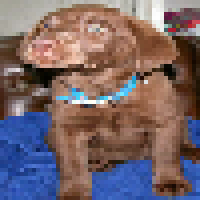

In [552]:
# Inspect a single datapoint from the batch
i = 1
arr = x_batch[i]
print("Label: {}".format(y_batch[i]))
print("Image data:")
img = array_to_img(arr, scale=True)
img.resize((200,200))

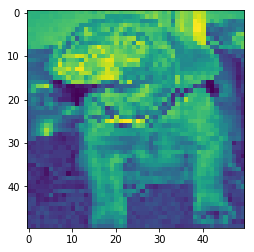

In [553]:
# Color channel 0 (r)
plt.imshow(arr[:,:,0])

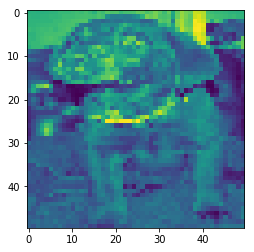

In [554]:
# Color channel 0 (g)
plt.imshow(arr[:,:,1])

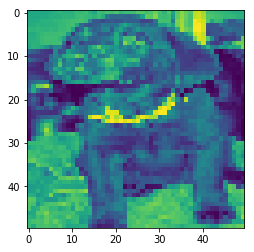

In [555]:
# Color channel 2 (b)
plt.imshow(arr[:,:,2])

In [556]:
# Check labels. After randomization the batch should contain zero's and one's
print(y_batch)

[0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1]


## Models

### CNN-2

CNN model with two convolutional two pooling layers, two dense layers and a dropout layer.

In [557]:
def cnn_model(features, labels, training):
    """Model function for CNN."""
    # Input Layer
    # Normalize features
    input_layer = (features - 110) / 255

    # Convolutional Layer #1
    with tf.variable_scope('conv1'):
        conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

    # Pooling Layer #1
    with tf.variable_scope('conv1'):
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and 
    with tf.variable_scope('conv2'):
        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    # Pooling Layer #2        
    with tf.variable_scope('pool2'):
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        print("Pool2 shape: {}".format(pool2.shape))

    # Dense Layer 1
    with tf.variable_scope('dense1'):
        pool2_flat = tf.reshape(pool2, [-1, 12 * 12 * 64])
        dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
        print("Dense1 shape: {}".format(dense.shape))
    
    # Dropout layer 1
    with tf.variable_scope('dropout1'):
        dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=training)

    # Output Layer
    with tf.variable_scope('logits'):
        logits = tf.layers.dense(inputs=dropout, units=1)

    with tf.variable_scope('predictions'):
        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          #"classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.sigmoid(logits)
        }
    
    return logits, predictions

## Training models

### CNN-2

In [574]:
# Define model
tf.reset_default_graph()
x, y = create_input_layer()
training = tf.placeholder_with_default(False, shape=None)
logits, predictions = cnn_model(x, y, training)

# Define loss
with tf.variable_scope('loss'):
    y_reshape = tf.reshape(y, (-1, 1))
    y_reshape = tf.to_float(y_reshape)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_reshape)
    loss = tf.reduce_mean(loss)
    train_loss_summary = tf.summary.scalar('loss_train', loss)
    val_loss_summary = tf.summary.scalar('loss_val', loss)
    all_summaries  = tf.summary.merge_all()

# Define optimization
with tf.variable_scope('train'):
    adam_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.9, beta2=0.999)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LR)
    train_op = adam_optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    # Variable initializer
    var_init = tf.global_variables_initializer()


Pool2 shape: (?, 12, 12, 64)
Dense1 shape: (?, 1024)


In [577]:
# Create session and start logging
logdir = sequential_dir('log/cat_dog')
print('logdir: {}'.format(logdir))
writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
sess = tf.InteractiveSession()
var_init.run()

logdir: log/cat_dog/run_07


In [578]:
# Training
for i in range(500):
    while True: # Keep generating new batches untill no error occurs
        try:
            _, loss_train, summary_str = sess.run([train_op, loss, train_loss_summary], feed_dict={training: True})
            break
        except InvalidArgumentError as ex:
            pass
    writer.add_summary(summary_str)
    print(i, loss_train)

0 0.68368113
1 0.6967895
2 0.71549314
3 0.6804397
4 0.6879889
5 0.6708884
6 0.70682794
7 0.6633297
8 0.69747496
9 0.6944026
10 0.69032395
11 0.6941691
12 0.66280115
13 0.67964
14 0.6460797
15 0.64549816
16 0.66785645
17 0.6690767
18 0.6552242
19 0.6542883
20 0.67187184
21 0.66461205
22 0.66136706
23 0.7054423
24 0.64827365
25 0.6976156
26 0.6582278
27 0.63213
28 0.6603167
29 0.71988213
30 0.6799097
31 0.6658032
32 0.6421307
33 0.63064647
34 0.6402601
35 0.64643
36 0.6307464
37 0.63528395
38 0.6752556
39 0.61346054
40 0.6704909
41 0.62824863
42 0.63517934
43 0.6013031
44 0.6532296
45 0.6201236
46 0.6075119
47 0.66531366
48 0.61159027
49 0.606989
50 0.60107267
51 0.6702008
52 0.6376544
53 0.6031378
54 0.6452141
55 0.5919393
56 0.6416087
57 0.6485821
58 0.5953615
59 0.6040244
60 0.6149645
61 0.65202326
62 0.601009
63 0.6540488
64 0.6274936
65 0.6311575
66 0.57150674
67 0.6190281
68 0.6379968
69 0.60294986
70 0.584872
71 0.6066064
72 0.6331728
73 0.5941422
74 0.56676245
75 0.62056506
76 0.

## Tutorial

### Tasks
- Compute accuracy
- Print layer dimensions
- Train with different learning rates
- Train with different optimizers
- Create different models
- Get the model to over fit

In [478]:
# Close the session
sess.close()